In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from scipy.sparse import hstack, csr_matrix


df = pd.read_csv("../../yikyak_metadata.csv")

TEXT_COL = "text_clean"
LABEL_COL = "high_engagement"

NUM_COLS = [
     "text_length", "created_hour", "first_person_count", "second_person_count", "first_person_ratio", "second_person_ratio",
    "disagree_count", "has_disagree", "conflict_count", "has_conflict", "exclamations", "questions", "vader_neg", "vader_neu", "vader_pos", "vader_compound",
    "posts_prev_2h_all","posts_prev_2h_group","rel_posts_prev_2h","burst_z_group","burst_flag_group",
]
use_cols = [TEXT_COL, LABEL_COL] + NUM_COLS
df_model = df[use_cols].dropna().copy()

df_model[NUM_COLS] = df_model[NUM_COLS].replace([np.inf, -np.inf], np.nan)
df_model[NUM_COLS] = df_model[NUM_COLS].fillna(0)

X_train_df, X_test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model[LABEL_COL]
)

y_train = X_train_df[LABEL_COL].values
y_test  = X_test_df[LABEL_COL].values


tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2
)


X_train_text = tfidf.fit_transform(X_train_df[TEXT_COL])
X_test_text  = tfidf.transform(X_test_df[TEXT_COL])

X_train_num = csr_matrix(X_train_df[NUM_COLS].astype(float).values)
X_test_num  = csr_matrix(X_test_df[NUM_COLS].astype(float).values)


scaler = StandardScaler(with_mean=False)
X_train_num = scaler.fit_transform(X_train_num)
X_test_num  = scaler.transform(X_test_num)

X_train = hstack([X_train_text, X_train_num])
X_test  = hstack([X_test_text, X_test_num])

logreg = LogisticRegression(
    C=1.0, 
    class_weight="balanced", 
    random_state=42,
    solver='liblinear',
    max_iter=2000 
)

logreg.fit(X_train, y_train)


y_probs = logreg.predict_proba(X_test)[:, 1]


threshold = 0.6
y_pred_tuned = (y_probs >= threshold).astype(int)

print(f"Classification Report:")
print(classification_report(y_test, y_pred_tuned))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3443
           1       0.24      0.33      0.28       382

    accuracy                           0.83      3825
   macro avg       0.58      0.61      0.59      3825
weighted avg       0.85      0.83      0.84      3825

Confusion Matrix:
[[3043  400]
 [ 256  126]]


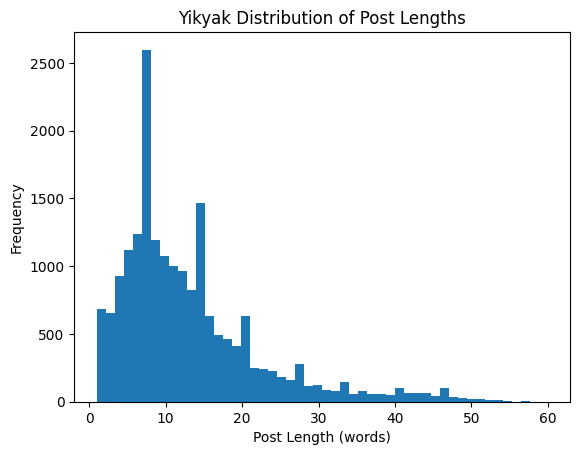

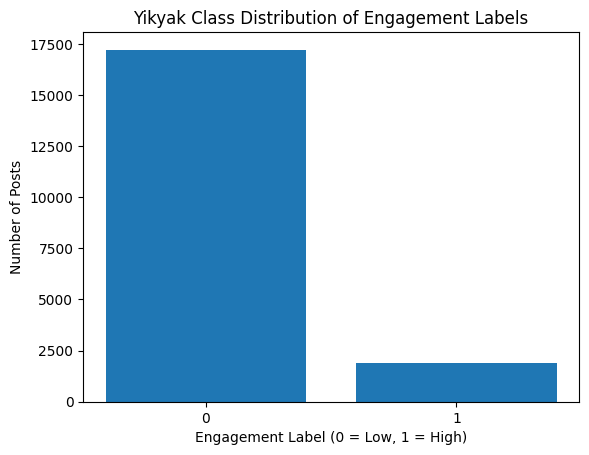

In [65]:

import matplotlib.pyplot as plt

df["post_length"] = df[TEXT_COL].str.split().str.len()

plt.figure()
plt.hist(df["post_length"], bins=50)
plt.xlabel("Post Length (words)")
plt.ylabel("Frequency")
plt.title("Yikyak Distribution of Post Lengths")
plt.show()


counts = df[LABEL_COL].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Engagement Label (0 = Low, 1 = High)")
plt.ylabel("Number of Posts")
plt.title("Yikyak Class Distribution of Engagement Labels")
plt.show()

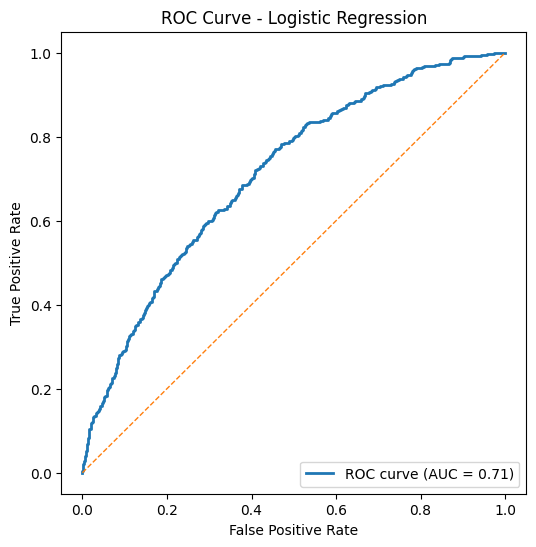

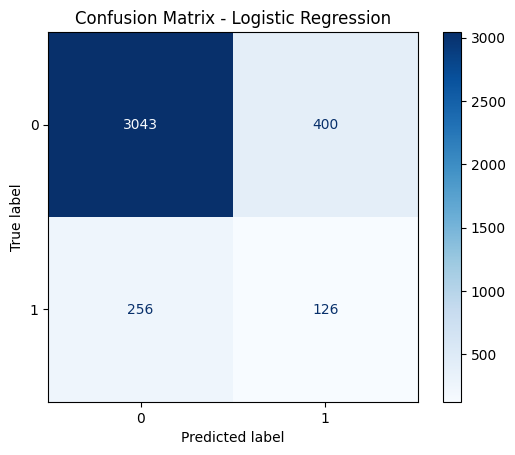

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Get predicted probabilities for the positive class
y_prob = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix using YOUR tuned threshold
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_tuned,
    cmap='Blues'
)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()
